In [1]:
from pyteomics import mgf
from pyteomics import mzxml
from pyteomics import mass

import pandas as pd
import numpy as np
import re
import pickle
import timeit
import time
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pylab import rcParams
from sklearn.metrics import r2_score

from scipy.stats import ttest_ind, spearmanr
import scipy.stats as stats
from scipy.stats import zscore

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

In [4]:
dfmerge  = pd.read_csv('P:/JGM_DI2A/Python/outputs/mitotox3/1ions12ppm_protein_quant_data_table.csv')

In [5]:
df6h = dfmerge[dfmerge['Control group']=='6 hr']
df24h = dfmerge[dfmerge['Control group']=='24h']
df24h.head()

,Unnamed: 0,key_0,Sample,Cell line,Genotype,Media,Compound,concentration,Treatment duration,Control group,...,xCX6B1_HUMAN,xTCTP_HUMAN,xMARE1_HUMAN,xRL30_HUMAN,xVDAC1_HUMAN,xFPPS_HUMAN,xTRAP1_HUMAN,xSYMC_HUMAN,xTXNL1_HUMAN,xRBM8A_HUMAN
84,84,85,85,293T,WT,DMEM,4-NB,1 mM,7 day,24h,...,0.060563,-0.594394,-0.079220,0.015354,-0.208599,0.357648,-0.244762,1.140630,1.692158,2.174907
85,85,86,86,293T,WT,DMEM,4-NB,1 mM,7 day,24h,...,0.987311,-0.615167,-1.319713,0.029817,-0.200257,0.702699,1.057101,1.262653,1.380081,1.602328
86,86,87,87,293T,WT,DMEM,4-NB,1 mM,7 day,24h,...,0.142307,-0.867102,-0.147405,-2.349797,-0.518479,0.161465,-0.129915,0.785918,1.034025,0.821583
87,87,88,88,293T,WT,HPLM,4-NB,1 mM,7 day,24h,...,0.606894,-0.820729,NaN,-0.045384,0.073957,0.674998,0.783918,1.463818,0.389657,0.773647
88,88,89,89,293T,WT,HPLM,4-NB,1 mM,7 day,24h,...,-0.077636,-0.619734,NaN,0.170500,-0.015437,0.470689,0.224004,1.243243,0.227852,0.699431


In [8]:
### flip so the controls are first
df24h = df24h.iloc[np.arange(-12, len(df24h)-12)]

In [59]:
df24h_hplm = df24h[df24h['Media']=='HPLM']
#df24h_hplm

In [50]:
df24h_dmem = df24h[df24h['Media']=='DMEM']
#df24h_dmem 

In [51]:
## DMEM control
print('DMEM control versus DMEM PPTC7 KO')
ttest_ind(df24h_dmem['xCISY_HUMAN'][0:3], df24h_dmem['xCISY_HUMAN'][3:6], equal_var=False)[1]

DMEM control versus DMEM PPTC7 KO


0.003462881007244627

In [52]:
## DMEM control
print('DMEM 4-NB, WT versus PPTC7 KO')
ttest_ind(df24h_dmem['xCISY_HUMAN'][6:9], df24h_dmem['xCISY_HUMAN'][9:12], equal_var=False)[1]


DMEM 4-NB, WT versus PPTC7 KO


0.01418556966669836

In [53]:
## DMEM control
print('DMEM DFO WT versus PPTC7 KO')
ttest_ind(df24h_dmem['xCISY_HUMAN'][12:15], df24h_dmem['xCISY_HUMAN'][15:18], equal_var=False)[1]

DMEM DFO WT versus PPTC7 KO


0.04811600937821357

In [54]:
## DMEM control
print('DMEM doxy WT versus PPTC7 KO')
ttest_ind(df24h_dmem['xCISY_HUMAN'][18:21], df24h_dmem['xCISY_HUMAN'][21:24], equal_var=False)[1]

DMEM doxy WT versus PPTC7 KO


0.15318086630011626

In [55]:
## DMEM control
print('HPLM control WT versus PPTC7 KO')
ttest_ind(df24h_hplm['xCISY_HUMAN'][0:3], df24h_hplm['xCISY_HUMAN'][3:6], equal_var=False)[1]

HPLM control WT versus PPTC7 KO


0.18550475457248347

In [56]:
## DMEM control
print('HPLM 4-NB, WT versus PPTC7 KO')
ttest_ind(df24h_hplm['xCISY_HUMAN'][6:9], df24h_hplm['xCISY_HUMAN'][9:12], equal_var=False)[1]

HPLM 4-NB, WT versus PPTC7 KO


0.06419319571889447

In [57]:
print('HPLM DFO WT versus PPTC7 KO')
ttest_ind(df24h_hplm['xCISY_HUMAN'][12:15], df24h_hplm['xCISY_HUMAN'][15:18], equal_var=False)[1]

HPLM DFO WT versus PPTC7 KO


0.034328396804177146

In [58]:
print('HPLM DOXY WT versus PPTC7 KO')
ttest_ind(df24h_hplm['xCISY_HUMAN'][18:21], df24h_hplm['xCISY_HUMAN'][21:24], equal_var=False)[1]

HPLM DOXY WT versus PPTC7 KO


0.012797171834253695

In [49]:
# save data table for source data
#df24h[df24h.columns.tolist()[0:10] + ['xCISY_HUMAN']].to_csv('P:/JGM_DI2A/Python/outputs/CISY_raw_data_table.csv')

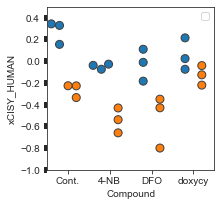

In [111]:
plt.rcParams['figure.figsize'] = 3,3
sns.set_style("ticks")
sns.set_context(font_scale= 12, rc={"ytick.major.width":6})

g = sns.swarmplot(x='Compound', y='xCISY_HUMAN', hue='Genotype', 
        data=df24h_dmem, dodge=True, size=8, linewidth=1)
g.set(ylim=(-1,0.5))
g.legend(labels=())
plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/Fig4D_CISY_HUMAN_DMEM_pts.svg')

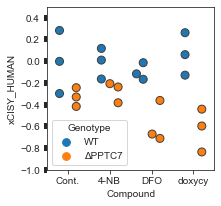

In [112]:
plt.rcParams['figure.figsize'] = 3,3
g = sns.swarmplot(x='Compound', y='xCISY_HUMAN', hue='Genotype', 
        data=df24h_hplm, dodge=True, size=8,  linewidth=1)
g.set(ylim=(-1,0.5))
#g.legend(labels=())
plt.savefig('P:/JGM_DI2A/Python/outputs/mitotox3/Fig4D_CISY_HUMAN_HPLM_pts.svg')